In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import math
from matplotlib import pyplot as plt
%matplotlib inline

#import seaborn as sns

from PIL import Image
from skimage import measure, io, color
from skimage.transform import resize, rescale
from skimage.measure import label, regionprops
from skimage.color import label2rgb
from skimage.morphology import convex_hull_image
from scipy.stats import mode
from sklearn.cluster import DBSCAN, KMeans

# os.chdir("/media/ryan/hdd/Dropbox/1_proj/logos/")
os.chdir("/Users/ryan/Dropbox/1_proj/logos/")

## Helper functions:

In [2]:
def alpha_to_color(image, color=(255, 255, 255)):
    """Alpha composite an RGBA Image with a specified color.

    Simpler, faster version than the solutions above.

    Source: http://stackoverflow.com/a/9459208/284318

    Keyword Arguments:
    image -- PIL RGBA Image object
    color -- Tuple r, g, b (default 255, 255, 255)

    """
    image.load()  # needed for split()
    background = Image.new('RGB', image.size, color)
    background.paste(image, mask=image.split()[3])  # 3 is the alpha channel
    return background

## Standardizes the color formatting:
def standardize(image):
    if len(image.shape)==2:
        image = color.gray2rgb(image)

    if len(image.shape)>3:
        image = image[:,:,:,0]

    if image.shape[2]==4:
        image = Image.fromarray(image)
        image = alpha_to_color(image)
        image = np.array(image)
        
    return image


## Removes the extra whitespace along the borders of the image:
def remove_white_bg(img):
    
    img_gray = color.rgb2gray(img)
    
    h, w = tuple(img_gray.shape)

    keep_row = np.ones(h, dtype='Bool')
    for row in range(h):
        keep_row[row] = (np.sum(np.sum(img_gray[row,:]<0.98,axis=0))>0)
        if keep_row[row]:
            break

    for row in reversed(range(h)):
        keep_row[row] = (np.sum(np.sum(img_gray[row,:]<0.98,axis=0))>0)
        if keep_row[row]:
            break

    keep_col = np.ones(w, dtype='Bool')
    for col in range(w):
        keep_col[col] = (np.sum(np.sum(img_gray[:,col]<0.98,axis=0))>0)
        if keep_col[col]:
            break
            
    for col in reversed(range(w)):
        keep_col[col] = (np.sum(np.sum(img_gray[:,col]<0.98,axis=0))>0)
        if keep_col[col]:
            break
                    

    img_nobg = img[keep_row,:]
    img_nobg = img_nobg[:,keep_col]
    
    return img_nobg


## Removes the extra background around a feature:
## (Why is this different than above???)
def remove_segmentation_bg(img):
      
    h, w = tuple(img.shape)

    keep_row = np.zeros(h, dtype='Bool')
    for row in range(h):
        keep_row[row] = (np.sum(img[row,:])>0)

    keep_col = np.ones(w, dtype='Bool')
    for col in range(w):
        keep_col[col] = (np.sum(img[:,col])>0)

    img_nobg = img[keep_row,:]
    img_nobg = img_nobg[:,keep_col]
    
    return img_nobg


## Adds some padding (extra white space) around an RGB feature:
## (Kind of the opposite of the above)
def add_padding(img, bgval, pad_size=20):
    side_pad = np.full((img.shape[0], pad_size, 3), bgval, dtype='uint8')
    tb_pad = np.full((pad_size, img.shape[1] + 2*pad_size, 3), bgval, dtype='uint8')
    padded_img = np.vstack((tb_pad, np.hstack((side_pad, img, side_pad)), tb_pad))
    return padded_img


## Same thing as above, but assuming a quantized image (integer pixels):
def add_quantized_padding(img, bgval=0, pad_size=20):
    side_pad = np.full((img.shape[0], pad_size), bgval, dtype='uint8')
    tb_pad = np.full((pad_size, img.shape[1] + 2*pad_size), bgval, dtype='uint8')
    padded_img = np.vstack((tb_pad, np.hstack((side_pad, img, side_pad)), tb_pad))
    return padded_img


## Detect what the background color is:
def detect_quantized_bg(img):
    from scipy.stats import mode
    corners = np.vstack((np.vstack(img[:10,:10]),np.vstack(img[:10,-10:]),np.vstack(img[-10:,:10]),np.vstack(img[-10:,-10:])))
    rowsums = np.sum(corners, axis=1)
    return mode(corners.flatten())[0][0]


## Rescale an image to have a given number of pixels (approximately):
def rescale_img(img, tot_pix=10000):
    h, w = tuple(img.shape[0:2])
    scale_factor = (h*w) / tot_pix
    return resize(img, (np.ceil(h / np.sqrt(scale_factor)).astype('uint8'), np.ceil(w / np.sqrt(scale_factor)).astype('uint8')))


## Rescale a feature to a standard small size:
def make_small_feature(feature, end_size = 25, max_size = 100.):

    h, w = tuple(feature.shape[0:2])

    if w==h:
        resized = resize(feature, (max_size, max_size))

    if w>h: 
        scale_factor = w/max_size
        resized = resize(feature, (np.ceil(h/scale_factor), max_size)) 

        padding_amount = max_size - np.ceil(h/scale_factor)
        top_pad = np.floor(padding_amount/2)
        bottom_pad = np.ceil(padding_amount/2)

        resized = np.concatenate([np.zeros((int(top_pad),int(max_size))), 
                                    resized, 
                                    np.zeros((int(bottom_pad),int(max_size)))], axis=0)

    if h>w: 
        scale_factor = h/max_size
        resized = resize(feature, (max_size, np.ceil(w/scale_factor))) 

        padding_amount = max_size - np.ceil(w/scale_factor)
        left_pad = np.floor(padding_amount/2)
        right_pad = np.ceil(padding_amount/2)

        resized = np.concatenate([np.zeros((int(max_size),int(left_pad))), 
                                    resized, 
                                    np.zeros((int(max_size),int(right_pad)))], axis=1)

    resized = resize(resized, (end_size, end_size))
    return resized

## Extraction:

This reads in the logo, and standardizes some aspects of it (color type, white space):

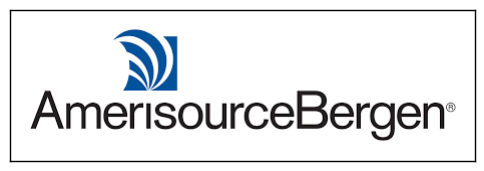

In [3]:
logo = 'amerisourcebergen.png'
name = logo.split(".")[0]

test = io.imread("data/new_sources/logos/" + logo)
test = standardize(test)
test = remove_white_bg(test)
test = add_padding(test, bgval=255)
#test = np.floor(255*rescale_img(test, tot_pix=20000)).astype('uint8')

fig = plt.figure()
plt.imshow(test)
plt.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')

Next, we want to decompose the logo into constituent features. The algorithm works as follows:

1. Detect how many colors are present, by converting to HSV color space, and clustering along the Hue dimension using the DBSCAN algorithm

2. Quantize the image, by assigning each pixel to one of the above clusters, thereby converting from HSV (or RGB) color space, to integers (quantized colors) --- we do this using kmeans, with cluster centers initialized at the RGB colors found by DBSCAN above

3. Look at the slices of the image corresponding to a given color, and perform a region-based segmentation, looking for elements that are fully separated by whitespace (in that slice)

The first function (hsv_segmentation) does steps 1 + 2 in the above. The next does step 3.

In [4]:
def hsv_segmentation(image, name="NA"):

    # WARNING: THIS SHOULD ONLY BE USED WITH SCIKIT-LEARN 0.15; OLDER AND NEWER VERSIONS HAVE LESS EFFICIENT IMPLEMENTATIONS OF DBSCAN THAT CAN CRASH YOUR COMPUTER DUE TO MEMORY CONSUMPTION!!

    from sklearn.cluster import DBSCAN, KMeans

    unsupervised = False
    ncolors = 0

    h, w, c = tuple(image.shape)
    rgbstacked = np.reshape(image, (h*w, c))

    hsvimage = color.rgb2hsv(image)
    hsvstacked = np.reshape(hsvimage, (h*w, c))
    
    labimage = color.rgb2lab(image)
    labstacked = np.reshape(labimage, (h*w, c))
    
    ## Look for non-greyscale pixels:
    goodpix = hsvstacked[np.bitwise_and(hsvstacked[:,1]>0.1, hsvstacked[:,2]>0.1),:]
    ngood = goodpix.shape[0]

    ## If there are non-grey pixels, figure out how many colors there are using DBSCAN:
    if ngood > 25:
        bw = False
        
        ## HSV is the cylindrical coordinate transformation of RGB, and Hue is defined as the 
        ## position around the circle of the coordinate system; therefore, to use DBSCAN clustering,
        ## we should look at the circular coordinate system 
        ## (This avoids unwanted things, like the color red existing at both h=0 and h=1)
        
        polar_hues = np.transpose(np.vstack((np.cos(2*math.pi*goodpix[:,0]),np.sin(2*math.pi*goodpix[:,0]))))
        round_cluster = DBSCAN(algorithm='ball_tree', eps=0.05, min_samples=25)
        round_cluster.fit(polar_hues)

        ncolors = np.sum(np.unique(round_cluster.labels_) != -1)

        ## Even if we find there is only one color, there could still be two colors that are
        ## very close together. In this step, we check if there is a large standard deviation 
        ## along any of the polar dimensions. If there is, let's assume there are actually two 
        ## colors. Then we will use a totally unsupervised kmeans clustering with two colors 
        ## plus whatever black/white centers we add below. 
        
        if ncolors==1:
            if np.any(np.std(polar_hues, axis=0) > 0.1):
                unsupervised = True
                
        if unsupervised == False:
            rgbgood = rgbstacked[np.bitwise_and(hsvstacked[:,1]>0.1, hsvstacked[:,2]>0.1),:]
            centers = np.vstack([np.median(rgbgood[round_cluster.labels_ == c,:], axis=0) for c in range(ncolors)])
    else:
        ncolors = 0
        bw = True


    # In this section, we try to figure out how many shades of gray there are. Usually, it's just white/black,
    # but we can use properties of the color distribution to guess whether there might also be a grey hidden there.
    # The problem is that grey is also the transition color between black/white, so we may find residual
    # traces of grey even if there is no actual grey.

    if unsupervised == False:
        bg = np.array([255.,255.,255.])
        n_nonbg = np.sum(np.any(rgbstacked != bg, axis=1))

        badpix = hsvstacked[np.bitwise_or(hsvstacked[:,1]<0.1, hsvstacked[:,2]<0.1),:]
        val = badpix[:,2]
        n_nonbg = np.sum(np.any(rgbstacked < 245, axis=1))
    
        if bw:
            centers = np.array([[255,255,255],
                                [0,0,0]])
        else:
            centers = np.vstack((centers, [255, 255, 255]))
            if np.sum(val < 0.2)/n_nonbg > 0.05:
                centers = np.vstack((centers, [0, 0, 0]))

        # If there are mid-range values, there is probably a grey in there; add a center:
        if np.sum(np.bitwise_and(val < 0.8, val > 0.2))/n_nonbg > 0.05:
            centers = np.vstack((centers, [125, 125, 125]))

    # Suppress warnings because kmeans doesn't like that we are using our own initial values:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        if unsupervised:
            km = KMeans(n_clusters=4)
            quantized = km.fit_predict(rgbstacked)
            centers = km.cluster_centers_

            coldist = np.bincount(quantized)/len(quantized)

            while np.any(coldist < 0.01):
                centers = centers[coldist > 0.01,:]
                km = KMeans(n_clusters=centers.shape[0], init=centers)
                quantized = km.fit_predict(rgbstacked)
                centers = km.cluster_centers_

                coldist = np.bincount(quantized)/len(quantized)            

        else:
            km = KMeans(n_clusters=centers.shape[0], init=centers)
            quantized = km.fit_predict(rgbstacked)
            centers = km.cluster_centers_

            coldist = np.bincount(quantized)/len(quantized)

            while np.any(coldist < 0.01):
                centers = centers[coldist > 0.01,:]
                km = KMeans(n_clusters=centers.shape[0], init=centers)
                quantized = km.fit_predict(rgbstacked)
                centers = km.cluster_centers_

                coldist = np.bincount(quantized)/len(quantized)

    df = pd.DataFrame({"name": name,
                       "r": km.cluster_centers_[:,0],
                       "g": km.cluster_centers_[:,1],
                       "b": km.cluster_centers_[:,2],
                       "area": np.bincount(quantized),
                       "frac": np.bincount(quantized)/len(quantized)})

    return (np.reshape(quantized, (h,w)), km.cluster_centers_, df[["name","area","frac","r","g","b"]])

In [5]:
quantized, centers, color_df = hsv_segmentation(test, name="test_name")
color_df

,name,area,frac,r,g,b
0,test_name,2848,0.040561,37.844803,33.842346,34.835323
1,test_name,1919,0.027330,8.361647,81.636790,152.214174
2,test_name,62634,0.892032,254.727863,254.741834,254.763323
3,test_name,1555,0.022146,5.409646,2.050161,2.688103
4,test_name,1259,0.017931,160.181890,163.216839,168.429706


In [6]:
def extract_features(quantized, centers, end_size=25):
    
    h, w = quantized.shape
    
    color_segments = np.unique(quantized)

    if np.any(np.sum(centers, axis=1)>(235.0*3)):
        qbg = np.argmax(np.sum(centers, axis=1))
    else:
        qbg = np.max(quantized)+1

    big_region = 1
    areas = []
    fracs = []
    
    quantized = add_quantized_padding(quantized, bgval=qbg)

    for r in range(len(color_segments)):        

        sub_labels = label((quantized == color_segments[r]))

        index = 1
    
        for region in regionprops(sub_labels):
        
            new_labels = np.zeros(sub_labels.shape)
            
            if (color_segments[r] == qbg) & (np.sum((sub_labels == index)[0:5,0:5]) > 5):
                continue
        
            if region.area > max(0.001*h*w,20):
            
                if (big_region == 1):
                    segmentation = np.expand_dims((sub_labels == index), 2)
                    segment_colors = centers[r,:]
                    
                else:
                    segmentation = np.append(segmentation, np.expand_dims((sub_labels == index), 2), axis=2)
                    segment_colors = np.vstack((segment_colors, centers[r,:]))
                
                areas = np.append(areas, region.area)
                fracs = np.append(fracs, region.area/(h*w))
                
                big_region += 1
                
            index += 1

    small_features = np.zeros((end_size, end_size, segmentation.shape[2]))
    for r in range(segmentation.shape[2]):
        small_features[:,:,r] = make_small_feature(remove_segmentation_bg(segmentation[:,:,r]), end_size = end_size)

    return small_features, segment_colors, areas, fracs

In [7]:
small_feats, feat_cols, areas, fracs = extract_features(quantized, centers)

/Users/ryan/anaconda3/envs/clusterenv/lib/python3.4/site-packages/ipykernel/__main__.py:76: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.


/Users/ryan/anaconda3/envs/clusterenv/lib/python3.4/site-packages/matplotlib/pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


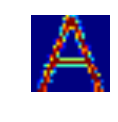

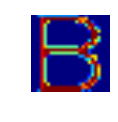

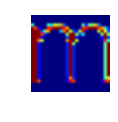

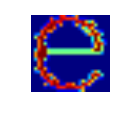

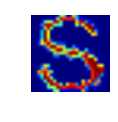

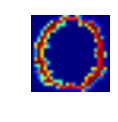

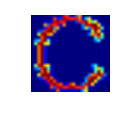

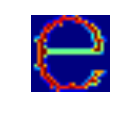

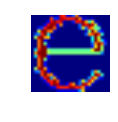

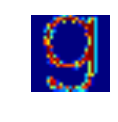

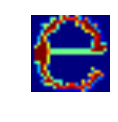

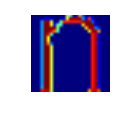

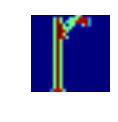

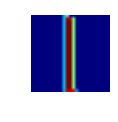

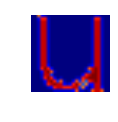

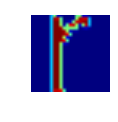

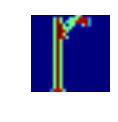

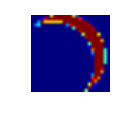

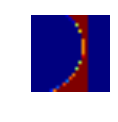

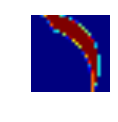

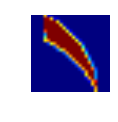

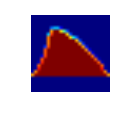

In [8]:
for s in range(small_feats.shape[2]):
    plt.figure(figsize=(1,1))
    plt.imshow(small_feats[:,:,s])
    plt.axis('off')

## Binary Features


In [9]:
grey_image = color.rgb2gray(test)
binary_image = grey_image < 0.6
np.mean(binary_image)

0.096190272733746349

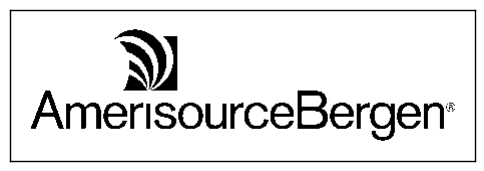

In [10]:
binary_test = binary_image
fig = plt.figure()
plt.imshow(binary_test, cmap='gray_r')
plt.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')

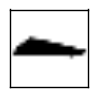

In [11]:
hull = make_small_feature(convex_hull_image(binary_test))
fig = plt.figure(figsize=(1,1))
plt.imshow(hull, cmap='gray_r')
plt.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')
# fig.savefig("../logos_paper/fig/inputs/hersheys_hull.pdf")

In [12]:
def extract_features_from_binary(quantized, end_size=25):
    
    ## Quantized in this case is just binary.
    
    h, w = quantized.shape
    
    color_segments = np.unique(quantized)

    big_region = 1
    isbg = np.empty(0)
    areas = []
    fracs = []
    
    quantized = add_quantized_padding(quantized)

    sub_labels = label((quantized == 1))

    index = 1

    for region in regionprops(sub_labels):

        new_labels = np.zeros(sub_labels.shape)

        if region.area > max(0.001*h*w, 20):

            if (big_region == 1):
                segmentation = np.expand_dims((sub_labels == index), 2)

            else:
                segmentation = np.append(segmentation, np.expand_dims((sub_labels == index), 2), axis=2)

            areas = np.append(areas, region.area)
            fracs = np.append(fracs, region.area/(h*w))

            big_region += 1

        index += 1

    small_features = np.zeros((end_size, end_size, segmentation.shape[2]))
    for r in range(segmentation.shape[2]):
        small_features[:,:,r] = make_small_feature(remove_segmentation_bg(segmentation[:,:,r]), end_size = end_size)

    return small_features, areas, fracs

In [13]:
bin_small_feats, bin_areas, bin_fracs = extract_features_from_binary(binary_test)

/Users/ryan/anaconda3/envs/clusterenv/lib/python3.4/site-packages/ipykernel/__main__.py:76: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.


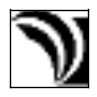

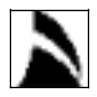

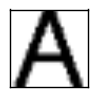

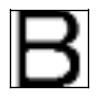

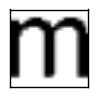

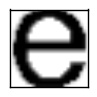

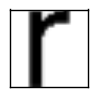

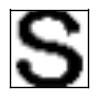

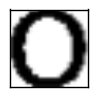

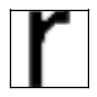

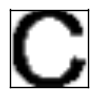

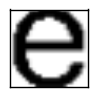

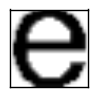

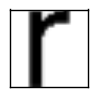

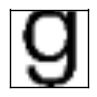

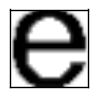

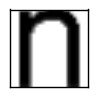

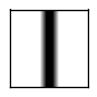

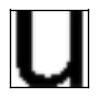

In [14]:
for s in range(bin_small_feats.shape[2]):
    fig = plt.figure(figsize=(1,1))
    plt.imshow(bin_small_feats[:,:,s], cmap='gray_r')
    plt.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')
#     fig.savefig("../logos_paper/fig/inputs/hersheys_comp-"+str(s)+".pdf")

The below has been modified to incorporate a true template matching routine:

In [15]:
from skimage.feature import match_template

def find_duplicate_features(bin_small_feats, small_feats, thresh=0.7):
    small_feats_concat = small_feats.transpose(0,2,1).reshape(25,-1)
    is_dup = np.array([np.max(match_template(small_feats_concat,bin_small_feats[:,:,i]))>thresh 
                          for i in range(bin_small_feats.shape[2])])
    
    return(is_dup)

In [16]:
is_dup = find_duplicate_features(bin_small_feats, small_feats)
is_dup

array([False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True, False], dtype=bool)

In [17]:
small_feats = np.append(small_feats, bin_small_feats[:,:,is_dup==False], axis=2)
areas = np.append(areas, bin_areas[is_dup==False])
fracs = np.append(fracs, bin_fracs[is_dup==False])

In [18]:
fracs

array([ 0.00408745,  0.00518408,  0.00326141,  0.00229296,  0.00210781,
        0.00222175,  0.00196539,  0.0020366 ,  0.00226447,  0.0039023 ,
        0.00246386,  0.00207933,  0.00103966,  0.00105391,  0.0018657 ,
        0.0014242 ,  0.00103966,  0.0086876 ,  0.00685039,  0.0056683 ,
        0.00193691,  0.00296233,  0.02201809,  0.00519832,  0.00370291])

/Users/ryan/anaconda3/envs/clusterenv/lib/python3.4/site-packages/matplotlib/pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


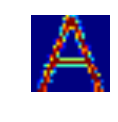

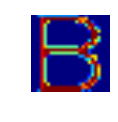

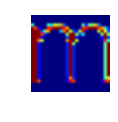

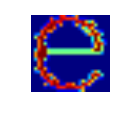

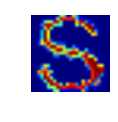

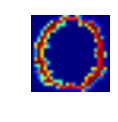

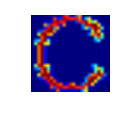

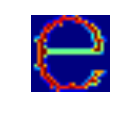

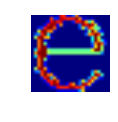

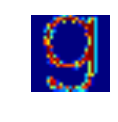

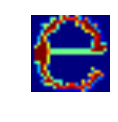

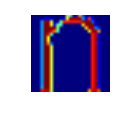

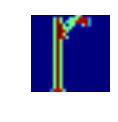

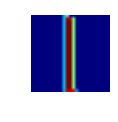

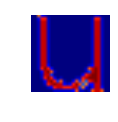

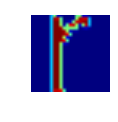

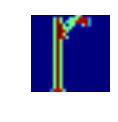

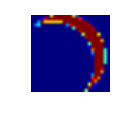

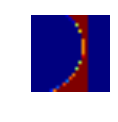

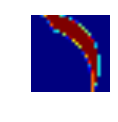

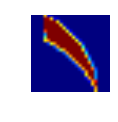

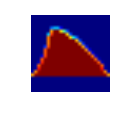

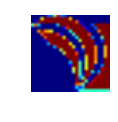

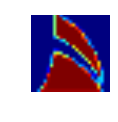

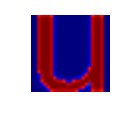

In [19]:
for s in range(small_feats.shape[2]):
    plt.figure(figsize=(1,1))
    plt.imshow(small_feats[:,:,s])
    plt.axis('off')

# Font detection using template matching:

In [20]:
fontdf = pd.read_csv("data/new_sources/font_features.csv")

In [21]:
fontmat = fontdf.iloc[:,0:625].values.astype('float')

In [22]:
# concat_fonts = np.hstack(tuple([fontmat[i,:].reshape(25,25) for i in range(fontmat.shape[1])]))

In [23]:
# tm = [np.max(match_template(concat_fonts,small_feats[:,:,i])) for i in range(small_feats.shape[2])]
# for s in range(small_feats.shape[2]):
#     plt.figure(figsize=(1,1))
#     plt.title(tm[s])
#     plt.imshow(small_feats[:,:,s])
#     plt.axis('off')

In [24]:
# s = 9
# assign = np.round(np.argmax(match_template(concat_fonts,small_feats[:,:,s])[0,:])/25.).astype('int')
# assign

In [25]:
# plt.imshow(small_feats[:,:,s])

In [26]:
# plt.imshow(fontdf.iloc[assign,:625].reshape(25,25).astype('float'))

So we just search in the template match for where the max occurs, divide that by 25 (the width of the search window), and round that to find which row of fontdf corresponds to the appropriate letter.

In [27]:
# font_assign = 9999*np.ones(small_feats.shape[2])
# for s in range(small_feats.shape[2]):
#     tm = match_template(concat_fonts,small_feats[:,:,s])
#     if np.max(tm) > 0.7:
#         font_assign[s] = round(np.argmax(tm)/25.)
# font_assign

In [28]:
# brand_font_assign_df = fontdf.iloc[font_assign[font_assign<9999].astype('int'),625:]
# brand_feats = small_feats[:,:,font_assign==9999]
# brand_feats_df = pd.DataFrame(np.transpose(np.reshape(brand_feats, (25*25, brand_feats.shape[2]))))

In [29]:
# brand_font_assign_df

In [30]:
# for s in range(brand_feats.shape[2]):
#     plt.figure(figsize=(1,1))
#     plt.imshow(brand_feats[:,:,s])
#     plt.axis('off')

Some characters like m or M or N have a harder time being identified. I think this is because the outside of the character may not align exactly with the templates, leading to low correlation. We can try running template matching over shrunken (cut-off) versions of the dictionary and character, to eliminate this problem, then take the max across iterations of template matching.

Note: run this using 21st Century Fox as the example to see this in action...

In [31]:
# np.round(np.argmax(match_template(concat_fonts,small_feats[2:23,2:23,10]))/25.)

In [32]:
# plt.imshow(fontmat[1807,:].reshape(25,25), cmap='gray')

In [33]:
# small_feats[3:22,3:22,10].shape

In [34]:
# plt.imshow(small_feats[0:25,0:25,10], cmap="gray")

In [35]:
# concat_fonts = np.hstack(tuple([fontmat[i,:].reshape(25,25)[3:22,3:22] for i in range(fontmat.shape[1])]))

In [36]:
# np.max(match_template(concat_fonts,small_feats[3:22,3:22,10]))

In [37]:
# [np.max(match_template(np.hstack(tuple([fontmat[i,:].reshape(25,25)[3:22,3:22] for i in range(fontmat.shape[1])])),
#                        small_feats[3:22,3:22,j])) for j in range(small_feats.shape[2])]

In [38]:
# shrink_scores = np.array([[np.max(match_template(np.hstack(tuple([fontmat[i,:].reshape(25,25)[k:(25-k),k:(25-k)] for i in range(fontmat.shape[1])])),
#                        small_feats[k:(25-k),k:(25-k),j])) for j in range(small_feats.shape[2])] for k in range(4)])

In [39]:
# np.max(shrink_scores,0)

Using amazon as the example, we find that the end of the amazon arrow is being found as a character. The reason seems to be that the template matching can find "in between" areas and identify them as characters. That is, above, template matching worked by just concatenating all the letters in one big image, then searching over that image to find instances of the feature in question. But that does not limit the search to searching over full characters---rather, the space between characters, which is there just as a byproduct of how we're setting up the search, can also be found as a "match" leading to high correlation, when in fact, there is no actual character with high correlation:

In [40]:
# plt.figure(figsize=(1,1))
# plt.imshow(small_feats[:,:,0])
# plt.axis('off')

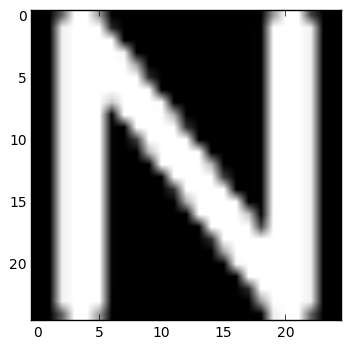

In [41]:
plt.imshow(fontmat[78,:].reshape(25,25), cmap='gray')

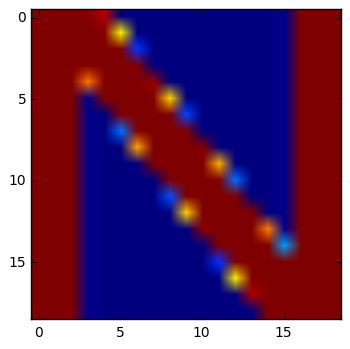

In [42]:
plt.imshow(fontmat[78,:].reshape(25,25)[3:22,3:22])

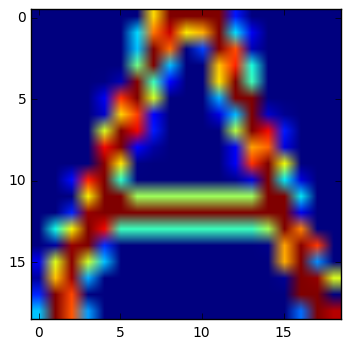

In [43]:
plt.imshow(small_feats[3:22,3:22,0])

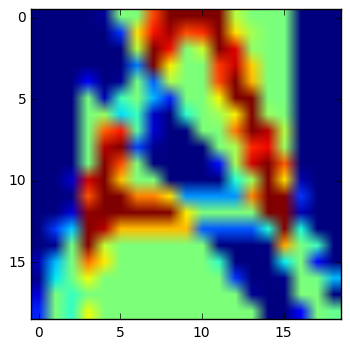

In [44]:
plt.imshow(small_feats[3:22,3:22,0]-fontmat[78,:].reshape(25,25)[3:22,3:22])

In [45]:
np.corrcoef(small_feats[3:22,3:22,0].flatten(), fontmat[77,:].reshape(25,25)[3:22,3:22].flatten())[0,1]

-0.17047848207127153

To solve that, we can implement our own template matching, just looking at correlations with the characters themselves, and not concatenating them:

In [46]:
# [np.max([np.corrcoef(small_feats[3:22,3:22,j].flatten(),
#                    fontmat[i,:].reshape(25,25)[3:22,3:22].flatten())[0,1] for i in range(fontmat.shape[0])]) for j in range(small_feats.shape[2])]

This appears to work pretty well...

In [47]:
# tm = np.array([[np.max([np.corrcoef(small_feats[k:(25-k),k:(25-k),j].flatten(),
#                                     fontmat[i,:].reshape(25,25)[k:(25-k),k:(25-k)].flatten())[0,1] 
#                         for i in range(fontmat.shape[0])]) 
#                 for j in range(small_feats.shape[2])] 
#                for k in range(3)])

In [48]:
# tm.shape

In [49]:
# score = np.max(tm,0)

In [50]:
# for s in range(small_feats.shape[2]):
#     plt.figure(figsize=(1,1))
#     plt.title(score[s])
#     plt.imshow(small_feats[:,:,s])
#     plt.axis('off')

But now (using 21st-century-fox), somehow, the letters that were OK before are actually not OK anymore... why???

In [51]:
# tm

In [52]:
# tm2 = np.array([[np.max([np.corrcoef(small_feats[k:(25-k),k:(25-k),j].flatten(),
#                                     fontmat[i,:].reshape(25,25)[k:(25-k),k:(25-k)].flatten())[0,1] 
#                         for i in range(fontmat.shape[0])]) 
#                 for j in range(small_feats.shape[2])] 
#          for k in range(1)])

# scores2 = np.max(tm2,0)

# for s in range(small_feats.shape[2]):
#     plt.figure(figsize=(1,1))
#     plt.title(scores2[s])
#     plt.imshow(small_feats[:,:,s])
#     plt.axis('off')

Doesn't really seem like I need the clipping procedure after this.

Using mastercard as the example above, we find very high hit rates for the simple shapes. Let's investigate that:

In [53]:
tm_explore = np.array([[np.corrcoef(small_feats[:,:,j].flatten(),
                                    fontmat[i,:].reshape(25,25).flatten())[0,1] 
                        for i in range(fontmat.shape[0])]
                for j in range(small_feats.shape[2])])

In [54]:
tm_explore.shape

(25, 4799)

In [55]:
np.max(tm_explore[0,:])

0.85014420190976159

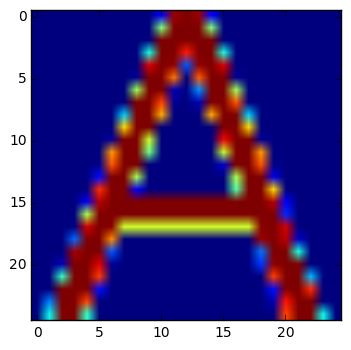

In [56]:
plt.imshow(fontmat[np.argmax(tm_explore[0,:]),:].reshape(25,25))

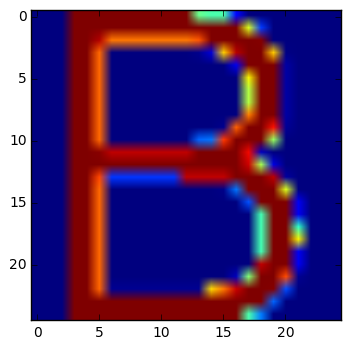

In [57]:
plt.imshow(fontmat[np.argmax(tm_explore[1,:]),:].reshape(25,25))

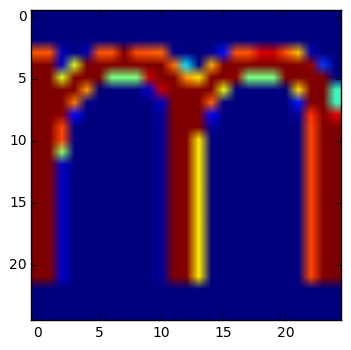

In [58]:
plt.imshow(fontmat[np.argmax(tm_explore[2,:]),:].reshape(25,25))

Maybe it's a problem for bold condensed fonts. We can see that in each case, the mark matched to some bold, condensed font that is basically just a blob.

In [59]:
top4 = np.argpartition(tm_explore[2,:], -4)[-4:]

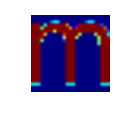

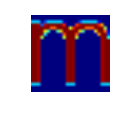

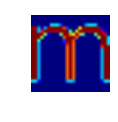

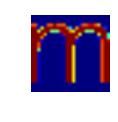

In [60]:
for s in range(len(top4)):
    plt.figure(figsize=(1,1))
    plt.imshow(fontmat[top4[s],:].reshape(25,25))
    plt.axis('off')

So all of these things are just like blocks (run above with mastercard). 

For these letters, I think we should have a higher threshold than with some of the more detailed fonts. 

I found a reference for something called "perimetric complexity" which is the inside and outside perimeter divided by the area of the figure. We could compute this and see how they rank. This seems like a good proxy for how complex the figure is.

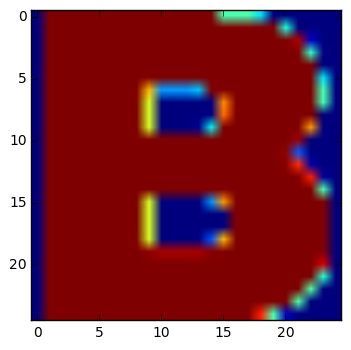

In [61]:
charimg = fontmat[3307,:].reshape(25,25)
plt.imshow(charimg)

In [62]:
from skimage import feature
padded = add_quantized_padding(charimg, pad_size=5)
area = np.sum(padded)
perim = np.sum(feature.canny(padded, sigma=1)).astype('float')
perim**2/area

32.631563568219867

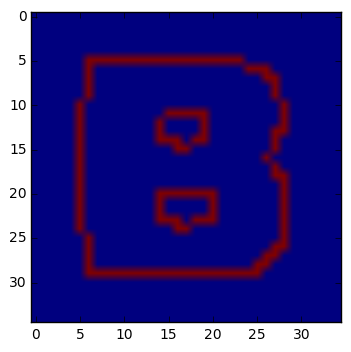

In [63]:
plt.imshow(feature.canny(padded, sigma=1))

In [64]:
def perimetric_complexity(charimg, sigma=1):
    padded = add_quantized_padding(charimg, pad_size=1)
    area = np.sum(padded)
    perim = np.sum(feature.canny(padded, sigma=sigma))
    return perim**2/(4.0*math.pi*area)

In [65]:
perimetric_complexity(charimg)

2.5967373213497993

In [66]:
pc = np.zeros(fontmat.shape[0])
for i in range(fontmat.shape[0]):
    pc[i] = perimetric_complexity(fontmat[i,:].reshape(25,25))

(array([  350.,  1178.,   974.,   887.,   644.,   408.,   215.,   102.,
           30.,    11.]),
 array([  1.33805901,   2.54263083,   3.74720265,   4.95177447,
          6.15634629,   7.36091812,   8.56548994,   9.77006176,
         10.97463358,  12.1792054 ,  13.38377722]),
 <a list of 10 Patch objects>)

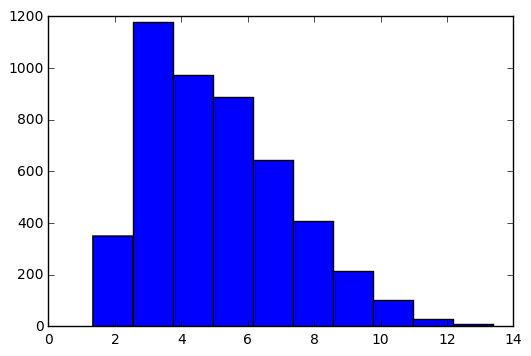

In [67]:
plt.hist(pc)

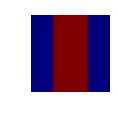

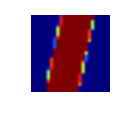

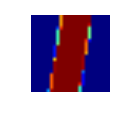

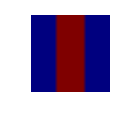

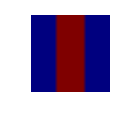

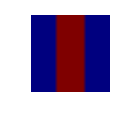

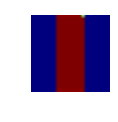

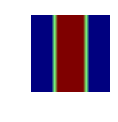

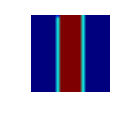

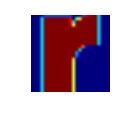

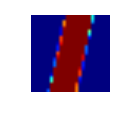

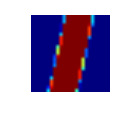

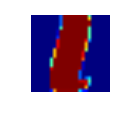

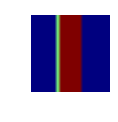

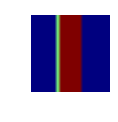

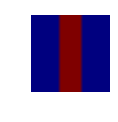

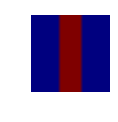

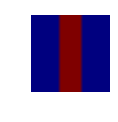

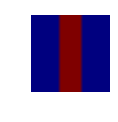

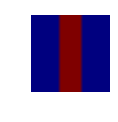

In [68]:
top_pc = np.argsort(pc)[:20]
for i in range(len(top_pc)):
    plt.figure(figsize=(1,1))
    plt.imshow(fontmat[top_pc[i],:].reshape(25,25))
    plt.axis('off')

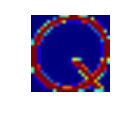

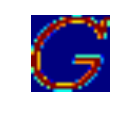

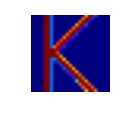

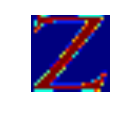

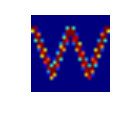

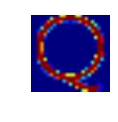

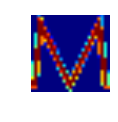

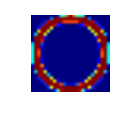

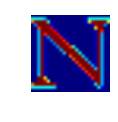

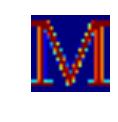

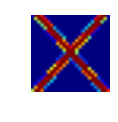

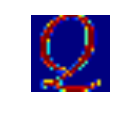

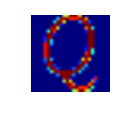

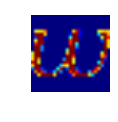

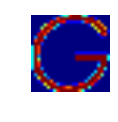

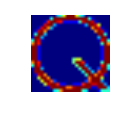

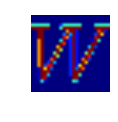

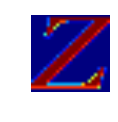

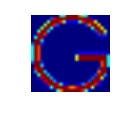

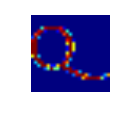

In [69]:
top_pc = np.argsort(pc)[-20:]
for i in range(len(top_pc)):
    plt.figure(figsize=(1,1))
    plt.imshow(fontmat[top_pc[i],:].reshape(25,25))
    plt.axis('off')

In [70]:
sorted_pc = np.argsort(pc)
weighting = np.array([np.where(sorted_pc==i)[0][0]*1.0 / len(sorted_pc) 
                      for i in range(len(pc))])
cutoff = 0.6+0.25*(1-weighting)

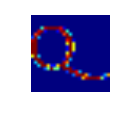

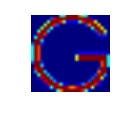

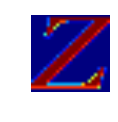

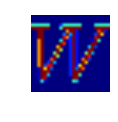

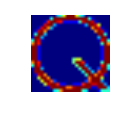

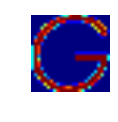

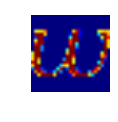

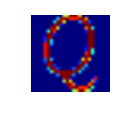

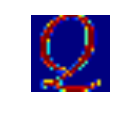

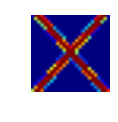

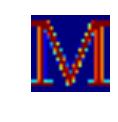

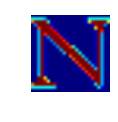

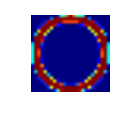

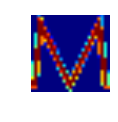

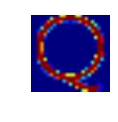

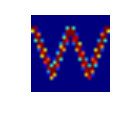

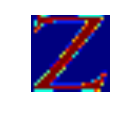

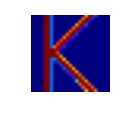

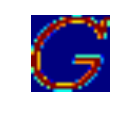

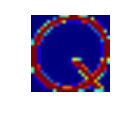

In [71]:
sortedcuts = np.argsort(cutoff)

for i in range(20):
    plt.figure(figsize=(1,1))
    plt.imshow(fontmat[sortedcuts[i],:].reshape(25,25))
    plt.axis('off')

In [72]:
cutoff[sortedcuts[:20]]

array([ 0.60005209,  0.60010419,  0.60015628,  0.60020838,  0.60026047,
        0.60031257,  0.60036466,  0.60041675,  0.60046885,  0.60052094,
        0.60057304,  0.60062513,  0.60067722,  0.60072932,  0.60078141,
        0.60083351,  0.6008856 ,  0.6009377 ,  0.60098979,  0.60104188])

So now, we have to do the following template matching:

 1. compute max just like before of small feats vs fonts
 
 2. identify fontmat argmax and the corresponding cutoff value
 
 3. label as font if corr exceeds cutoff

In [73]:
tm_scores = np.array([[np.corrcoef(small_feats[:,:,j].flatten(),
                                    fontmat[i,:].reshape(25,25).flatten())[0,1] 
                        for i in range(fontmat.shape[0])]
                for j in range(small_feats.shape[2])])

In [74]:
np.amax(tm_scores, axis=1)

array([ 0.8501442 ,  0.78532957,  0.81764234,  0.72276201,  0.74473612,
        0.83300359,  0.77898701,  0.72233368,  0.73061207,  0.80729881,
        0.73237489,  0.82834302,  0.87616224,  0.96018144,  0.80602801,
        0.8910443 ,  0.87616224,  0.47375801,  0.77702392,  0.45232503,
        0.63816305,  0.67510668,  0.29588571,  0.6061812 ,  0.88199275])

In [75]:
cutoff[np.argmax(tm_scores, axis=1)]

array([ 0.65006251,  0.62443217,  0.63110023,  0.62411961,  0.64417587,
        0.60213586,  0.61302355,  0.60213586,  0.62411961,  0.6098979 ,
        0.61891019,  0.68616378,  0.79280058,  0.77300479,  0.61786831,
        0.79280058,  0.79280058,  0.67720358,  0.7846218 ,  0.8392165 ,
        0.64605126,  0.84744738,  0.8392165 ,  0.84380079,  0.72236924])

/Users/ryan/anaconda3/envs/clusterenv/lib/python3.4/site-packages/matplotlib/pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


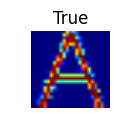

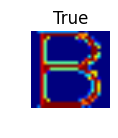

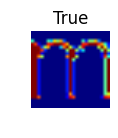

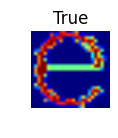

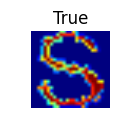

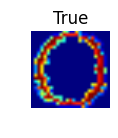

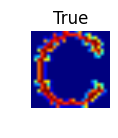

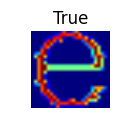

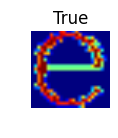

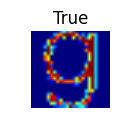

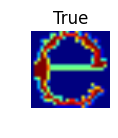

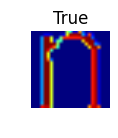

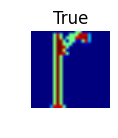

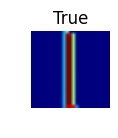

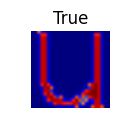

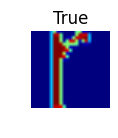

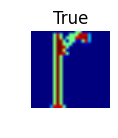

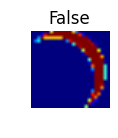

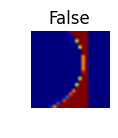

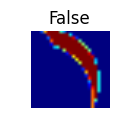

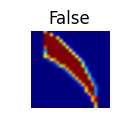

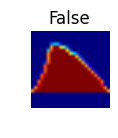

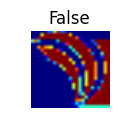

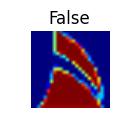

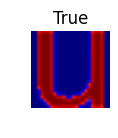

In [76]:
is_char = np.amax(tm_scores, axis=1) > cutoff[np.argmax(tm_scores, axis=1)]
for s in range(small_feats.shape[2]):
    plt.figure(figsize=(1,1))
    plt.title(is_char[s])
    plt.imshow(small_feats[:,:,s])
    plt.axis('off')

In [77]:
perimetric_complexity(fontmat[np.argmax(tm_scores, axis=1)[-5],:].reshape((25,25)))

7.1043590700078267

In [78]:
np.min(pc)

1.3380590124671345

/Users/ryan/anaconda3/envs/clusterenv/lib/python3.4/site-packages/matplotlib/pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


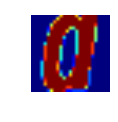

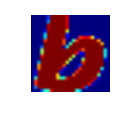

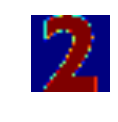

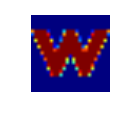

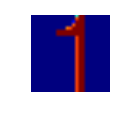

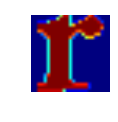

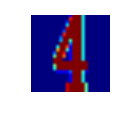

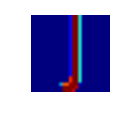

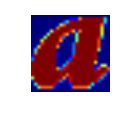

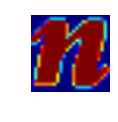

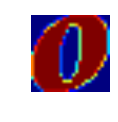

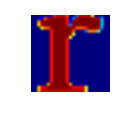

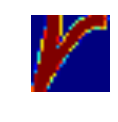

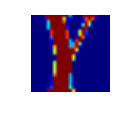

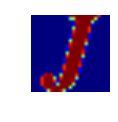

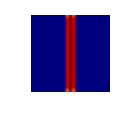

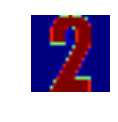

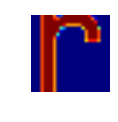

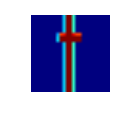

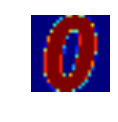

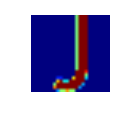

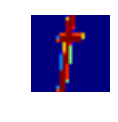

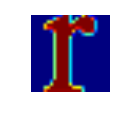

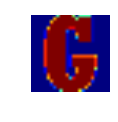

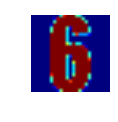

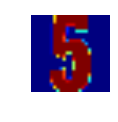

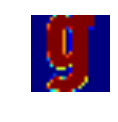

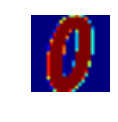

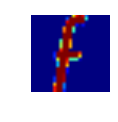

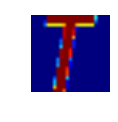

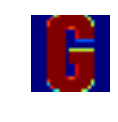

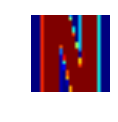

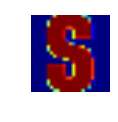

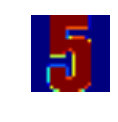

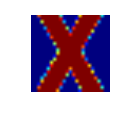

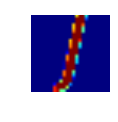

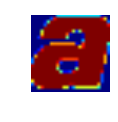

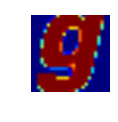

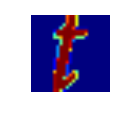

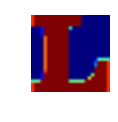

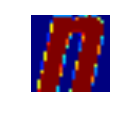

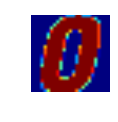

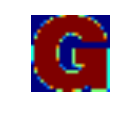

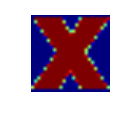

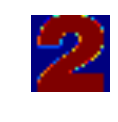

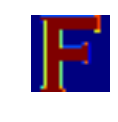

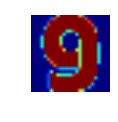

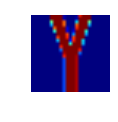

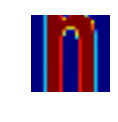

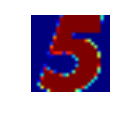

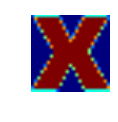

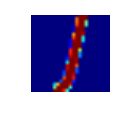

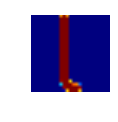

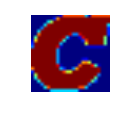

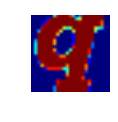

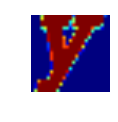

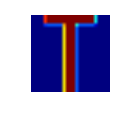

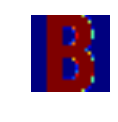

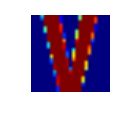

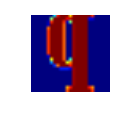

In [79]:
for i in np.where(np.bitwise_and(pc > 3.5, pc < 3.55))[0]:
    plt.figure(figsize=(1,1))
    plt.imshow(fontmat[i,:].reshape(25,25))
    plt.axis('off')

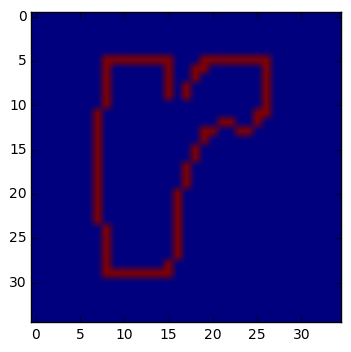

In [80]:
plt.imshow(feature.canny(add_quantized_padding(fontmat[np.where(np.bitwise_and(pc > 1.99, pc < 2.01))[0][-7],:].reshape((25,25)), pad_size=5), sigma=1))

In [81]:
np.where(np.bitwise_and(pc > 1.99, pc < 2.05))[0]

array([ 433,  445,  585, 1203, 1487, 1726, 1768, 1781, 1798, 1813, 1825,
       1885, 2114, 2474, 2578, 2598, 2599, 2708, 2711, 2796, 2797, 3099,
       3230, 3313, 3506, 3538, 3730, 3752, 3879, 4038, 4167, 4247, 4302,
       4333, 4568, 4656, 4676])

Not satisfied with the above, what about a simpler system:

In [82]:
cutoff = np.zeros(len(pc))
for i in range(len(pc)):
    if pc[i] < 2.0:
        cutoff[i] = 0.85
#     elif pc[i] < 2.5:
#         cutoff[i] = 0.8
    else:
        cutoff[i] = 0.75

/Users/ryan/anaconda3/envs/clusterenv/lib/python3.4/site-packages/matplotlib/pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


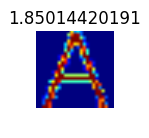

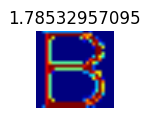

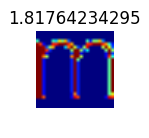

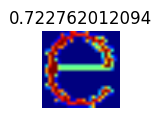

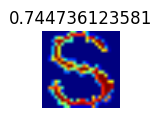

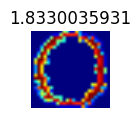

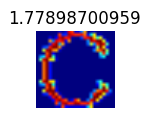

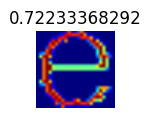

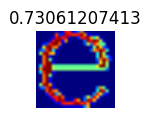

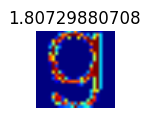

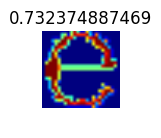

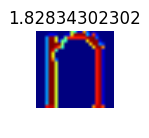

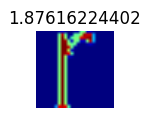

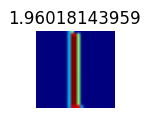

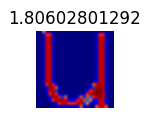

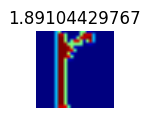

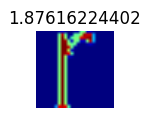

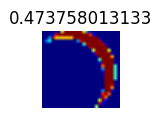

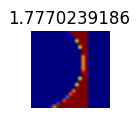

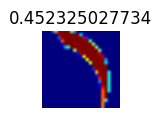

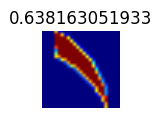

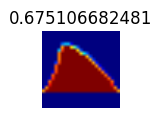

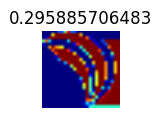

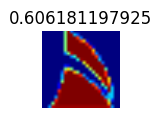

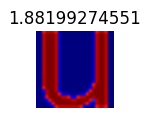

In [83]:
is_char = np.amax(tm_scores, axis=1) > cutoff[np.argmax(tm_scores, axis=1)]
scores = np.amax(tm_scores, axis=1)
for s in range(small_feats.shape[2]):
    plt.figure(figsize=(1,1))
    plt.title(is_char[s] + scores[s])
    plt.imshow(small_feats[:,:,s])
    plt.axis('off')

In [84]:
np.amax(tm_scores, axis=1)

array([ 0.8501442 ,  0.78532957,  0.81764234,  0.72276201,  0.74473612,
        0.83300359,  0.77898701,  0.72233368,  0.73061207,  0.80729881,
        0.73237489,  0.82834302,  0.87616224,  0.96018144,  0.80602801,
        0.8910443 ,  0.87616224,  0.47375801,  0.77702392,  0.45232503,
        0.63816305,  0.67510668,  0.29588571,  0.6061812 ,  0.88199275])

In [85]:
np.argmax(tm_scores, axis=1)

array([ 725,  726,  767, 1624,  773,  722,  720,  722, 1624,  766,  765,
       2049,  772, 2003, 1610,  772,  772, 1044, 2212, 4056,  273, 4390,
       4056, 4247, 1894])

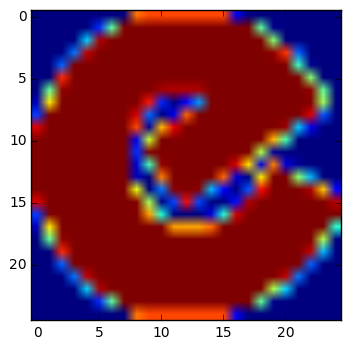

In [86]:
plt.imshow(fontmat[3753,:].reshape((25,25)))

In [87]:
perimetric_complexity(fontmat[3753,:].reshape((25,25)))

3.6099100174831955

In [88]:
perimetric_complexity(small_feats[:,:,small_feats.shape[2]-1])

5.0159111220561927

In [89]:
assignments = np.argmax(tm_scores, axis=1)
pc_assigned = np.zeros(small_feats.shape[2])
for s in range(small_feats.shape[2]):
    pc_assigned[s] = perimetric_complexity(fontmat[assignments[s],:].reshape((25,25)))

In [90]:
pc_actual = np.zeros(small_feats.shape[2])
for s in range(small_feats.shape[2]):
    pc_actual[s] = perimetric_complexity(small_feats[:,:,s])

In [91]:
pc_assigned - pc_actual

array([-1.83995436, -4.9483223 , -2.06269937, -6.43420145, -5.71802606,
       -1.21324948, -2.15454705, -6.11388657, -6.44298807, -4.59291989,
       -4.69436372, -3.29628205, -2.229543  ,  0.46598761, -2.01446077,
       -1.27032654, -2.229543  ,  1.34373117, -0.21438357, -1.40946112,
        3.59932605,  0.17388206, -8.0877028 , -2.23374844, -0.13381087])

If you run the mastercard version of this, you find a problem: a circle is being assigned to a similar shape (e). This implies we could use a different rule: either a two step rule, where we look and see first where the template matches are, then discard those of different perimetric complexities, or we could actually do a bi-directional complexity comparison

/Users/ryan/anaconda3/envs/clusterenv/lib/python3.4/site-packages/matplotlib/pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


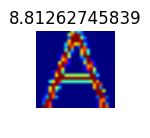

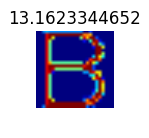

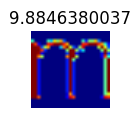

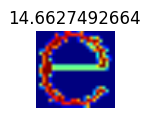

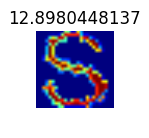

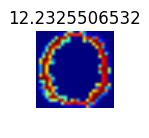

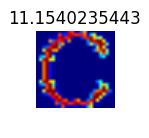

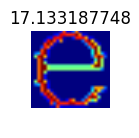

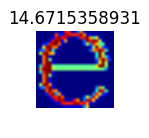

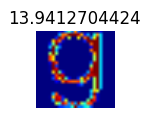

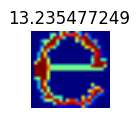

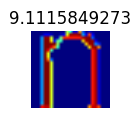

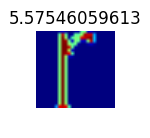

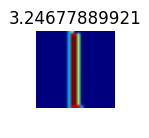

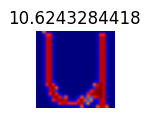

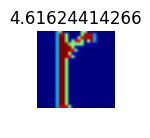

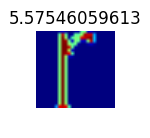

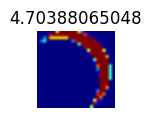

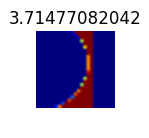

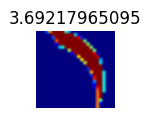

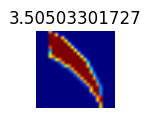

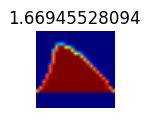

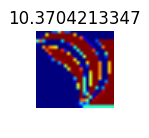

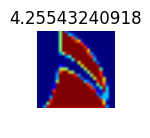

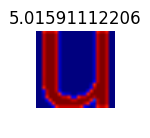

In [97]:
for s in range(small_feats.shape[2]):
    plt.figure(figsize=(1,1))
    plt.title(pc_actual[s])
    plt.imshow(small_feats[:,:,s])
    plt.axis('off')

In [101]:
is_char = np.zeros(small_feats.shape[2]).astype("bool")
for s in range(small_feats.shape[2]):
    if pc_actual[s] < 4.0:
        if scores[s] > 0.85:
            is_char[s] = True
    else:
        if scores[s] > 0.7:
            is_char[s] = True

In [102]:
is_char

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False, False, False, False, False, False,  True], dtype=bool)

/Users/ryan/anaconda3/envs/clusterenv/lib/python3.4/site-packages/matplotlib/pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


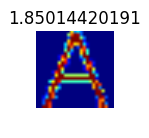

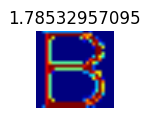

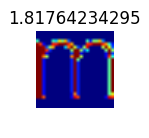

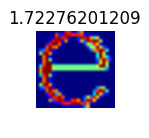

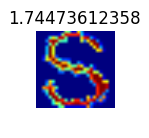

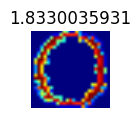

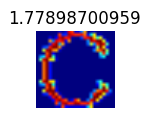

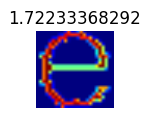

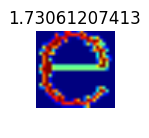

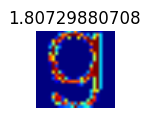

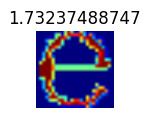

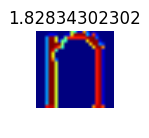

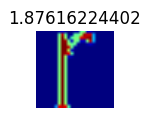

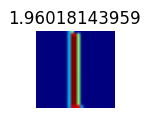

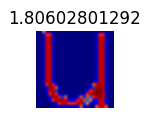

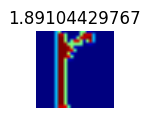

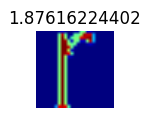

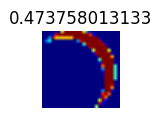

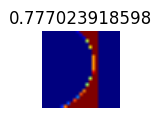

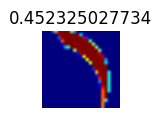

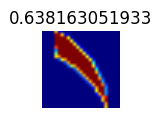

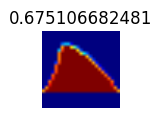

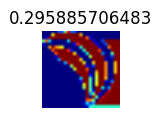

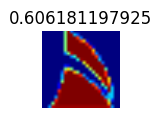

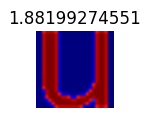

In [103]:
for s in range(small_feats.shape[2]):
    plt.figure(figsize=(1,1))
    plt.title(is_char[s] + scores[s])
    plt.imshow(small_feats[:,:,s])
    plt.axis('off')

I'm happy with this. I don't see any need to continue iterating on this version

In [95]:
concat_letters = np.hstack(tuple([small_feats[:,:,i] for i in np.where(is_char)[0]]))

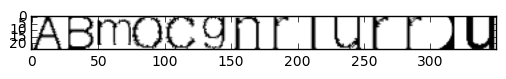

In [96]:
plt.imshow(1-concat_letters, cmap="gray")